# OFC-2 Data Example

Data is freely available and described in detail here: https://crcns.org/data-sets/ofc/ofc-2

I wrote some (somewhat ugly) code to collect the data into a nice format, see `OFC-2-wrangle-data.ipynb`.

The time warping code works nicely when the data are organized as follows:

* Spike times are encoded by three 1d arrays: `trials`, `times`, `neurons`. The arrays are the same length, and hold the number of spikes in the dataset:
```python
len(trials) == len(times) == len(neurons) = # total number of spikes in the dataset
```
* For the `i`-th spike in the data:
```python
trials[i] = # integer number, the trial that the i-th spike was fired on
times[i] = # integer number, the time bin of the spike within the trial
neurons[i] = # integer number, the index of the neuron that fired the spike
```
* You can also store the spiking data in a sparse 3d tensor by using the [sparse](https://sparse.pydata.org/en/latest/) package provided by the PyData organization (link to [github](https://github.com/pydata/sparse)).
```
total_spikes = len(times)
spikedata = sparse.COO((trials, times, neurons), np.ones(total_spikes))
```
* The time warping is fit on binned spike counts but the warping functions are applied to the raw spike times. Here, the binned spike counts were pre-computed and are held in the variable `binned`.
```python
binned = # n_trials x n_timebins x n_neurons, holding spike counts in each bin
```
* Note that the timebins should be linearly spaced within each trial. The package has a helper function to bin spikes for you:
```python
from affinewarp import bin_spikes
binned = bin_spikes(spikedata, 100)  # 100 timebins
binned = bin_spikes((trials, times, neurons), 100)  # also works...
```
* In this notebook we fit the warping functions to the neural data, but then apply those warping functions to behavioral events which are held in `metadata`. Specifically, we will plot the timing of reward onset in clock time and after warping as red dots on raster plots. `metadata['water_on']` is a 1d array holding the time (normalized to range from zero to one) of water onset for each trial.
```python
len(metadata['water_on']) = # n_trials
```

The model is implemented in the `AffineWarping` class, which has an API inspired by the [`scikit-learn`](http://scikit-learn.org/) library. The basic procedure is:
```python
from affinewarp import PiecewiseWarping
model = PiecewiseWarping()
model.fit(binned)
aligned_spikes = model.transform_events(spikedata)
```
There are some customizable options in the `PiecewiseWarping` class:
* `n_knots` : integer number of discontinuities in the warping function (`n_knots = 0` gives linear warpings).
* `l2_smoothness` : nonnegative decimal number penalizing the trial-average template learned by the model.

In [1]:
# See OFC-2-wrangle-data.ipynb for procedure to download and pre-process data #

# load data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import deepdish as dd
ofc2 = dd.io.load('ofc2_data.h5')

# spike times 
trials = ofc2['trials']
times = ofc2['times']
neurons = ofc2['neurons']

# dict holding trials specific data
#    - metadata['water_on'] gives the time that the reward water turned on each trial
metadata = ofc2['metadata']

In [2]:
from affinewarp import SpikeData

data = SpikeData(trials, times, neurons, 0., 6e4)

n_bins = 100
binned = data.bin_spikes(n_bins)
n_trials = binned.shape[0]

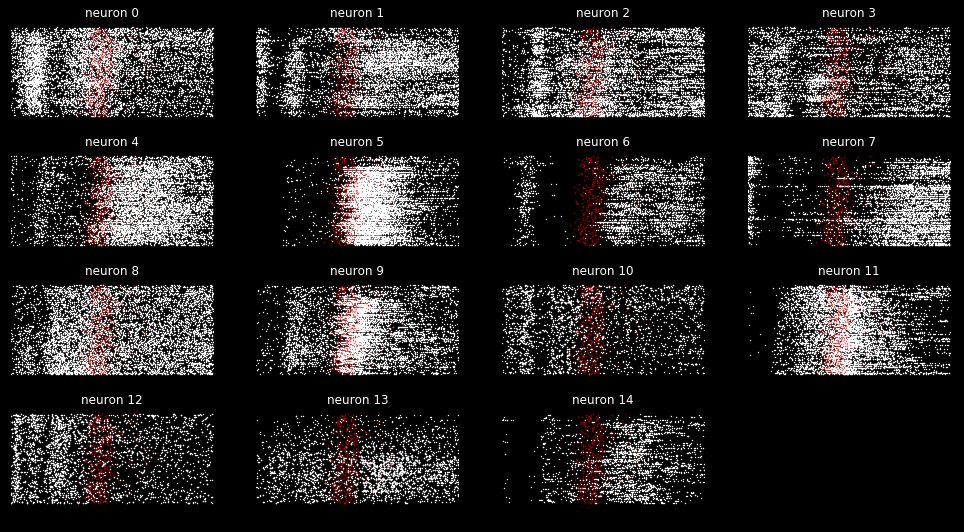

In [3]:
from affinewarp.visualization import rasters

fig, axes = rasters(data, subplots=(4, 4), s=2);
for ax in axes.ravel()[:-1]:
    ax.scatter(metadata['water_on'], np.arange(data.n_trials), c='r', s=.5, alpha=.5)

100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Text(0,0.5,'reconstruction error')

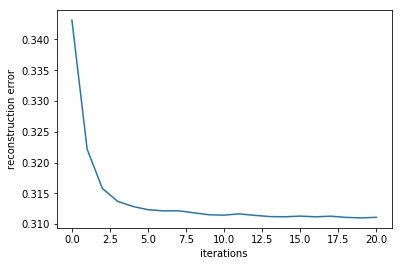

In [4]:
from affinewarp import PiecewiseWarping
model = PiecewiseWarping(n_knots=0)

# fit model and show loss history
model.fit(binned, iterations=20, warp_iterations=20)
plt.plot(model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('reconstruction error')

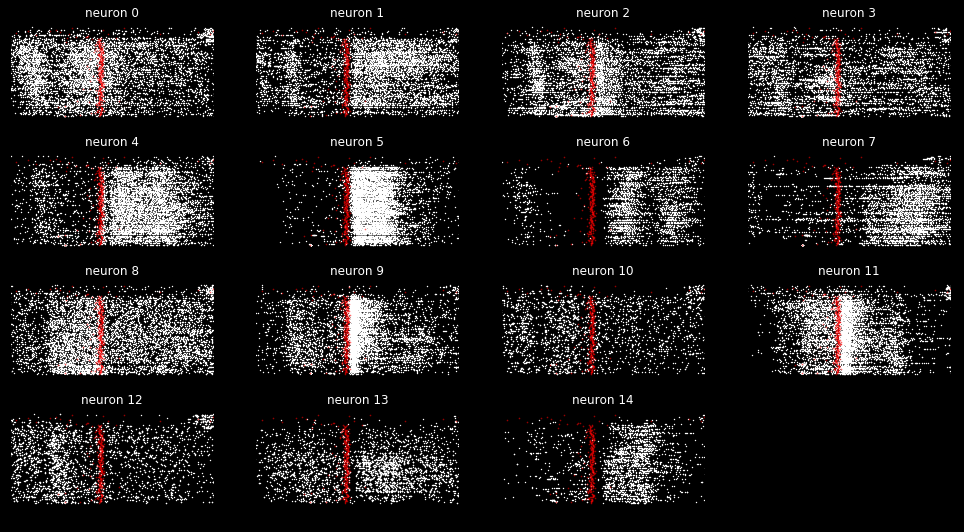

In [5]:
# warp each spike
warped_spikes = model.transform(data)

# warp the onset of reward for each trial
warped_water = 6e4 * model.event_transform(np.arange(data.n_trials), metadata["water_on"] / 6e4)

# plot rasters
fig, axes = rasters(warped_spikes, subplots=(4, 4), s=2);

# plot water onset
K = len(binned)
for ax in axes.ravel()[:-1]:
    ax.scatter(warped_water, np.arange(data.n_trials), c='r', s=.5, alpha=.5)    

100%|██████████| 20/20 [00:00<00:00, 23.86it/s]


Text(0,0.5,'reconstruction error')

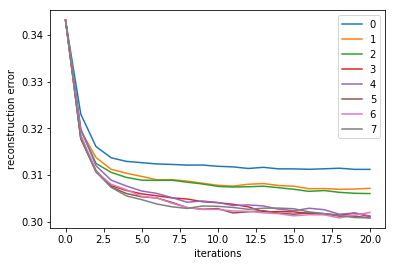

In [6]:
# see if adding more discontinuities to the warping function makes the model fit better.
for knots in range(8):
    model = PiecewiseWarping(n_knots=knots)
    model.fit(binned, iterations=20, warp_iterations=20)
    plt.plot(model.loss_hist, label=knots)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('reconstruction error')